## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('RawData')

In [5]:
type(mylist)

list

In [6]:
print(mylist[18])

01-01-01-01-01-01-19.wav


In [7]:
print(mylist[40][6:-16])

01


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('RawData/01-01-01-01-01-01-01.wav')

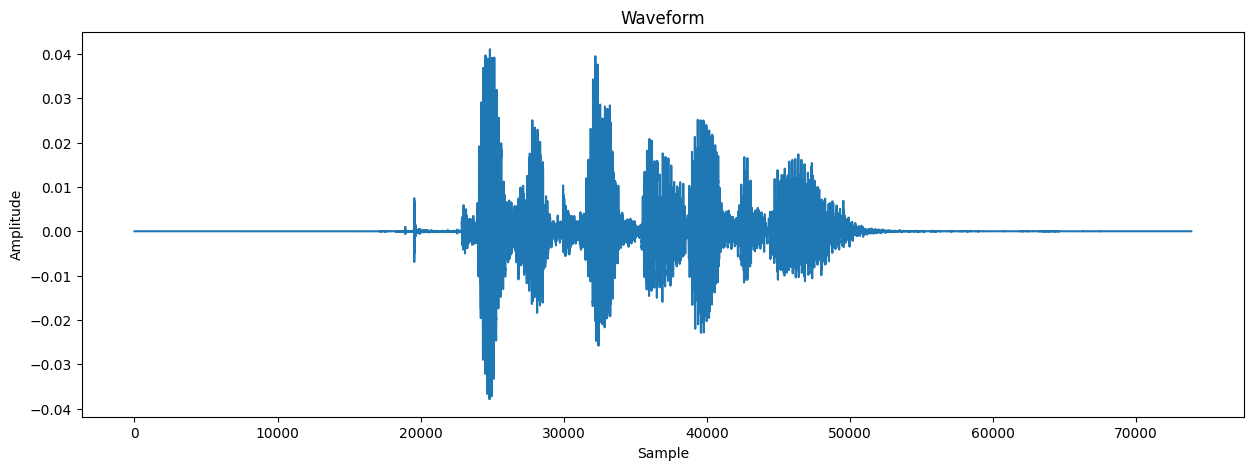

In [9]:
import os
import pandas as pd
import librosa
import glob

plt.figure(figsize=(15, 5))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

C:\Users\91797\AppData\Local\Temp\ipykernel_4084\149416596.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('RawData/03-02-01-01-01-01-01.wav')
C:\Users\91797\AppData\Local\Temp\ipykernel_4084\149416596.py:26: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


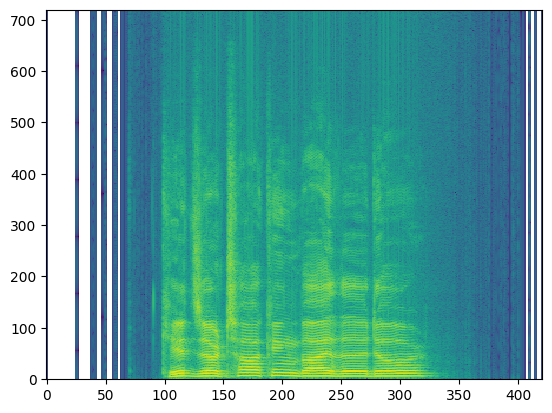

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-02-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [12]:
import pandas as pd
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [ ]:
#!pip install resampy

In [14]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [15]:
df[:5]

,feature
0,"[-70.272285, -70.272285, -70.272285, -70.27228..."
1,"[-65.80567, -65.80567, -65.80567, -65.80567, -..."
2,"[-65.44599, -65.44599, -65.44599, -65.44599, -..."
3,"[-64.46406, -64.46406, -64.46406, -64.46406, -..."
4,"[-63.372505, -60.7444, -63.910282, -59.630398,..."


In [16]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [17]:
newdf = pd.concat([df3,labels], axis=1)

In [18]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [19]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.272285,-70.272285,-70.272285,-70.272285,-70.272285,-70.272285,-70.272285,-70.272285,-70.272285,-70.272285,...,-58.008541,-57.713211,-58.124676,-57.226460,-59.274860,-58.143837,-57.362064,-59.439438,-64.136917,male_calm
1,-65.805672,-65.805672,-65.805672,-65.805672,-65.805672,-63.790241,-61.673241,-61.319710,-65.199089,-62.384293,...,-37.727665,-37.456318,-38.548965,-39.844769,-40.861412,-41.406181,-41.616848,-44.653728,-50.297665,female_calm
2,-65.445992,-65.445992,-65.445992,-65.445992,-65.445992,-65.445992,-65.445992,-65.445992,-65.445992,-65.445992,...,-28.373573,-27.868483,-29.274662,-31.785458,-34.431480,-35.685768,-36.174313,-37.789886,-39.847660,male_calm
3,-64.464058,-64.464058,-64.464058,-64.464058,-64.464058,-64.464058,-64.464058,-64.464058,-64.464058,-64.464058,...,-50.549198,-49.532169,-48.823116,-48.628208,-48.408585,-47.124966,-42.664646,-42.437477,-41.201931,female_calm
4,-63.372505,-60.744400,-63.910282,-59.630398,-58.011433,-60.749863,-67.762711,-72.383759,-63.419033,-62.261700,...,-37.892448,-33.626507,-34.463722,-39.929363,-42.235561,-40.906940,-37.920525,-36.457909,-38.835598,male_calm


In [20]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
4137,-41.031155,-41.003624,-41.240646,-41.145061,-40.974197,-41.150436,-41.100883,-40.883854,-41.034431,-41.171833,...,-30.646025,-31.902601,-35.397640,-34.608810,-33.978470,-34.653854,-35.896835,-36.721428,-39.347527,female_happy
4384,-56.165428,-56.166897,-56.158165,-54.663876,-55.167160,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265,...,-56.157265,-56.157265,-56.157265,-55.844578,-56.157265,-56.157265,-56.157265,-56.157265,-56.157265,male_angry
1772,-58.624931,-57.461250,-53.985653,-51.360935,-50.830032,-50.530090,-52.243633,-52.399185,-52.332764,-51.379757,...,-45.008579,-44.266251,-43.735954,-43.757038,-42.204311,-41.707890,-42.667759,-27.868282,-19.750813,female_fearful
3092,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,...,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,female_happy
2260,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,...,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,male_happy
4318,-58.401588,-58.123432,-57.216331,-57.138840,-58.032345,-57.584698,-57.990635,-57.497719,-57.415119,-58.088760,...,-39.392483,-40.890751,-42.336868,-43.509972,-42.349056,-42.181870,-45.077202,-46.274563,-42.694279,male_sad
3949,-54.837151,-47.600090,-47.243469,-49.781620,-51.013920,-51.757805,-52.709618,-50.911385,-51.240993,-52.116287,...,-51.703342,-52.721413,-52.037918,-51.599422,-52.917747,-56.011021,-57.615841,-57.347652,-58.944946,female_calm
2779,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,...,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,female_fearful
2937,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,...,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,female_calm
1086,-55.185379,-53.075111,-53.467281,-54.020565,-54.266827,-54.523197,-53.511333,-53.171047,-53.012413,-53.575161,...,-46.260063,-47.617264,-45.275009,-42.681900,-39.617737,-37.421696,-40.254509,-29.657064,-21.655882,female_calm


In [21]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [22]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [23]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
3170,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,...,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,male_happy
5013,-51.568111,-49.874039,-50.680157,-52.331711,-52.400597,-51.999596,-51.597065,-52.289768,-52.271927,-50.465523,...,-28.546511,-27.131680,-26.655170,-24.668968,-24.579824,-22.241987,-20.859324,-18.114128,-16.954378,male_happy
4583,-56.134243,-53.989563,-54.817200,-52.090519,-50.502365,-48.636532,-47.764980,-48.702255,-49.846069,-51.278358,...,-43.140991,-47.167965,-47.926292,-46.764839,-47.443829,-48.654465,-48.569500,-48.754166,-46.378189,female_fearful
2998,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,...,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,female_calm
622,-54.723755,-54.723755,-54.723755,-54.723755,-54.723755,-54.723755,-54.723755,-54.723755,-54.723755,-54.723755,...,-53.991219,-54.632549,-54.723755,-54.022781,-53.077003,-53.670815,-54.662277,-52.753689,-51.189102,male_angry
3201,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,...,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,male_happy
702,-38.374413,-39.004089,-39.208195,-39.581455,-40.082909,-39.800133,-39.578133,-39.609367,-39.757301,-39.941936,...,-21.268223,-21.564280,-21.603031,-20.132786,-18.220568,-16.832369,-16.668495,-16.519318,-14.795304,male_angry
3335,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,...,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,-87.028526,male_sad
5332,-50.030315,-48.408024,-48.741062,-50.468185,-48.835793,-47.511356,-48.187614,-46.571270,-46.422714,-48.874367,...,-21.634857,-22.665499,-22.030876,-21.397291,-22.133593,-22.934553,-23.381107,-20.438469,-15.760763,male_angry
5580,-45.404175,-44.712196,-44.920124,-43.818474,-42.694412,-42.324993,-43.835506,-44.708366,-45.120827,-44.854794,...,-32.719326,-33.221779,-32.460678,-34.853691,-32.189171,-32.162472,-26.218801,-19.297649,-14.079779,female_fearful


In [24]:
trainfeatures = train.iloc[:, :-1]

In [25]:
trainlabel = train.iloc[:, -1:]

In [26]:
testfeatures = test.iloc[:, :-1]

In [27]:
testlabel = test.iloc[:, -1:]

In [ ]:
!pip install np_utils

In [28]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

'''
import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
'''

D:\python\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\python\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'\nimport np_utils\nfrom sklearn.preprocessing import LabelEncoder\n\nX_train = np.array(trainfeatures)\ny_train = np.array(trainlabel)\nX_test = np.array(testfeatures)\ny_test = np.array(testlabel)\n\nlb = LabelEncoder()\n\ny_train = np_utils.to_categorical(lb.fit_transform(y_train))\ny_test = np_utils.to_categorical(lb.fit_transform(y_test))\n'

In [29]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [30]:
X_train.shape

(4504, 216)

## Changing dimension for CNN model

In [31]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [32]:
import tensorflow as tf

In [39]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00001, decay=1e-6)
#opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout (Dropout)           (None, 216, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 27, 128)           0         
 D)                                                              
                                                        

In [43]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [44]:
cnnhistory=model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
282/282 [==============================] - 8s 28ms/step - loss: 1.4567 - accuracy: 0.4494 - val_loss: 1.6521 - val_accuracy: 0.3592
Epoch 2/200
282/282 [==============================] - 8s 27ms/step - loss: 1.4530 - accuracy: 0.4440 - val_loss: 1.6199 - val_accuracy: 0.3838
Epoch 3/200
282/282 [==============================] - 8s 28ms/step - loss: 1.4566 - accuracy: 0.4505 - val_loss: 1.6265 - val_accuracy: 0.3794
Epoch 4/200
282/282 [==============================] - 8s 28ms/step - loss: 1.4508 - accuracy: 0.4527 - val_loss: 1.6304 - val_accuracy: 0.3706
Epoch 5/200
282/282 [==============================] - 8s 27ms/step - loss: 1.4458 - accuracy: 0.4558 - val_loss: 1.6104 - val_accuracy: 0.3838
Epoch 6/200
282/282 [==============================] - 9s 34ms/step - loss: 1.4443 - accuracy: 0.4520 - val_loss: 1.6272 - val_accuracy: 0.3715
Epoch 7/200
282/282 [==============================] - 8s 27ms/step - loss: 1.4449 - accuracy: 0.4458 - val_loss: 1.6216 - val_accuracy:

282/282 [==============================] - 8s 28ms/step - loss: 1.3506 - accuracy: 0.4956 - val_loss: 1.5894 - val_accuracy: 0.3935
Epoch 58/200
282/282 [==============================] - 8s 28ms/step - loss: 1.3485 - accuracy: 0.4893 - val_loss: 1.5788 - val_accuracy: 0.3882
Epoch 59/200
282/282 [==============================] - 8s 28ms/step - loss: 1.3457 - accuracy: 0.4944 - val_loss: 1.5712 - val_accuracy: 0.3952
Epoch 60/200
282/282 [==============================] - 8s 28ms/step - loss: 1.3403 - accuracy: 0.4960 - val_loss: 1.5775 - val_accuracy: 0.3961
Epoch 61/200
282/282 [==============================] - 8s 28ms/step - loss: 1.3452 - accuracy: 0.4989 - val_loss: 1.5992 - val_accuracy: 0.3944
Epoch 62/200
282/282 [==============================] - 8s 30ms/step - loss: 1.3469 - accuracy: 0.4978 - val_loss: 1.5954 - val_accuracy: 0.3926
Epoch 63/200
282/282 [==============================] - 8s 29ms/step - loss: 1.3408 - accuracy: 0.4996 - val_loss: 1.5638 - val_accuracy: 0.416

282/282 [==============================] - 8s 28ms/step - loss: 1.2499 - accuracy: 0.5364 - val_loss: 1.5590 - val_accuracy: 0.4058
Epoch 114/200
282/282 [==============================] - 8s 28ms/step - loss: 1.2484 - accuracy: 0.5377 - val_loss: 1.6350 - val_accuracy: 0.3882
Epoch 115/200
282/282 [==============================] - 8s 28ms/step - loss: 1.2426 - accuracy: 0.5471 - val_loss: 1.5812 - val_accuracy: 0.3988
Epoch 116/200
282/282 [==============================] - 8s 28ms/step - loss: 1.2449 - accuracy: 0.5422 - val_loss: 1.5446 - val_accuracy: 0.4032
Epoch 117/200
282/282 [==============================] - 8s 28ms/step - loss: 1.2419 - accuracy: 0.5446 - val_loss: 1.5465 - val_accuracy: 0.3970
Epoch 118/200
282/282 [==============================] - 8s 28ms/step - loss: 1.2389 - accuracy: 0.5402 - val_loss: 1.5611 - val_accuracy: 0.3961
Epoch 119/200
282/282 [==============================] - 8s 28ms/step - loss: 1.2370 - accuracy: 0.5431 - val_loss: 1.5760 - val_accuracy:

282/282 [==============================] - 8s 28ms/step - loss: 1.1502 - accuracy: 0.5799 - val_loss: 1.5643 - val_accuracy: 0.4040
Epoch 170/200
282/282 [==============================] - 8s 29ms/step - loss: 1.1448 - accuracy: 0.5848 - val_loss: 1.5289 - val_accuracy: 0.4049
Epoch 171/200
282/282 [==============================] - 8s 29ms/step - loss: 1.1454 - accuracy: 0.5886 - val_loss: 1.5686 - val_accuracy: 0.3988
Epoch 172/200
282/282 [==============================] - 8s 29ms/step - loss: 1.1435 - accuracy: 0.5850 - val_loss: 1.5682 - val_accuracy: 0.4164
Epoch 173/200
282/282 [==============================] - 8s 28ms/step - loss: 1.1449 - accuracy: 0.5786 - val_loss: 1.5224 - val_accuracy: 0.4234
Epoch 174/200
282/282 [==============================] - 8s 29ms/step - loss: 1.1408 - accuracy: 0.5855 - val_loss: 1.5576 - val_accuracy: 0.4067
Epoch 175/200
282/282 [==============================] - 8s 29ms/step - loss: 1.1355 - accuracy: 0.5959 - val_loss: 1.5708 - val_accuracy:

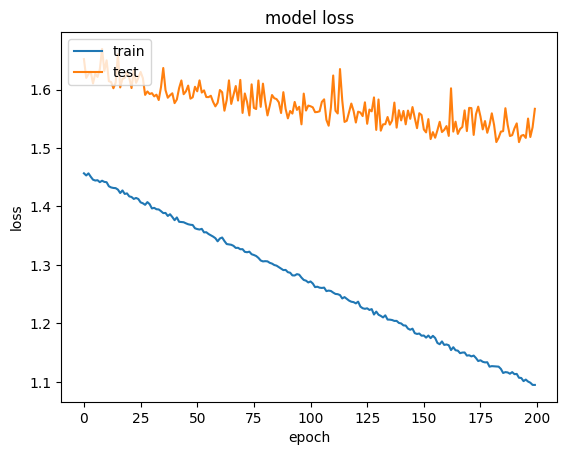

In [45]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [46]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

D:\python\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved trained model at D:\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [47]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [48]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 41.29%


## Predicting emotions on the test data

In [49]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

36/36 [==============================] - 2s 21ms/step


In [50]:
preds

array([[1.07370631e-03, 7.66194463e-02, 1.91004187e-01, ...,
        1.28414522e-05, 1.93942222e-04, 2.82473866e-05],
       [2.52133667e-01, 2.20698668e-04, 2.82893836e-01, ...,
        1.59005215e-03, 1.24728340e-05, 3.57890190e-06],
       [3.26335765e-02, 5.64083815e-01, 1.86253563e-02, ...,
        3.23336195e-07, 8.37749940e-06, 4.49314568e-04],
       ...,
       [8.48457813e-02, 2.25515634e-01, 1.15628511e-01, ...,
        6.77099973e-02, 8.90520290e-02, 5.93119301e-02],
       [6.99982285e-01, 2.08595466e-07, 1.17620715e-04, ...,
        2.66363233e-01, 2.16729343e-02, 1.18872488e-03],
       [1.15533943e-07, 2.17345197e-17, 1.34017671e-14, ...,
        3.67173721e-04, 7.51207117e-05, 1.05540865e-08]], dtype=float32)

In [51]:
preds1=preds.argmax(axis=1)

In [52]:
preds1

array([3, 3, 1, ..., 1, 0, 5], dtype=int64)

In [53]:
abc = preds1.astype(int).flatten()

In [54]:
predictions = (lb.inverse_transform((abc)))

In [55]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_happy
1,female_happy
2,female_calm
3,female_calm
4,male_calm
5,male_angry
6,female_calm
7,female_calm
8,female_calm
9,female_calm


In [56]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [57]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_happy
1,female_fearful
2,female_calm
3,male_calm
4,male_calm
5,male_angry
6,female_calm
7,female_sad
8,female_happy
9,female_angry


In [58]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [59]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_angry,male_angry
171,male_fearful,female_calm
172,female_calm,female_calm
173,male_sad,female_calm
174,female_happy,female_happy
175,female_sad,female_calm
176,male_calm,male_calm
177,female_angry,female_angry
178,male_happy,male_fearful
179,male_sad,female_calm


In [60]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,113
female_calm,117
female_fearful,97
female_happy,110
female_sad,113
male_angry,103
male_calm,129
male_fearful,111
male_happy,127


In [61]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,66
female_calm,501
female_fearful,60
female_happy,96
female_sad,43
male_angry,84
male_calm,76
male_fearful,71
male_happy,85


In [62]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [74]:
data, sampling_rate = librosa.load('output11.wav')

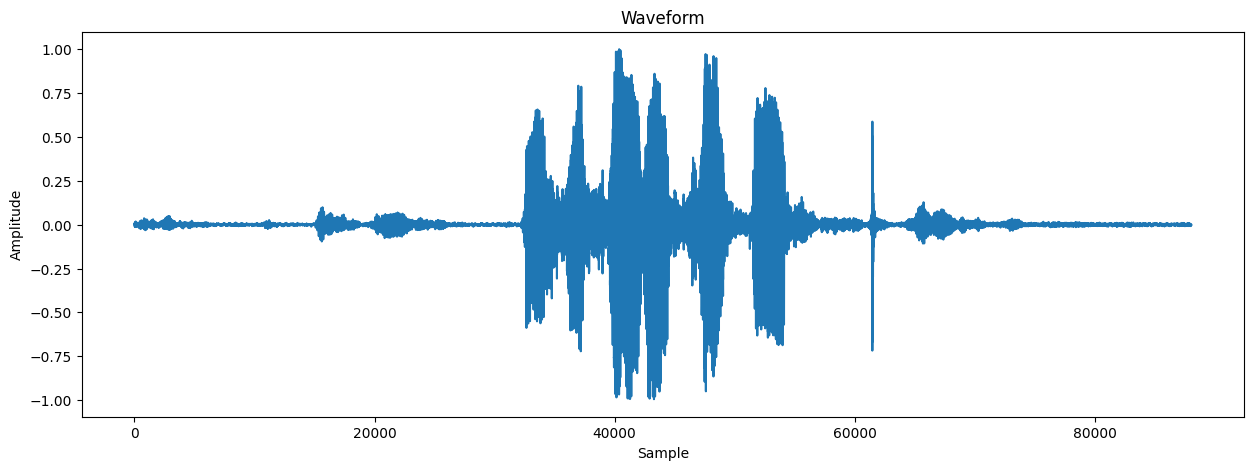

In [75]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [76]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output11.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [77]:
livedf2= pd.DataFrame(data=livedf2)

In [78]:
livedf2 = livedf2.stack().to_frame().T

In [79]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-9.761906,-6.222051,-8.274036,-12.460909,-10.602855,-8.996101,-6.334488,-6.437235,-7.73454,-6.723973,...,-24.973537,-26.45047,-26.633091,-25.753416,-25.509907,-24.304018,-24.166939,-23.361935,-23.214071,-25.014017


In [80]:
twodim= np.expand_dims(livedf2, axis=2)

In [81]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 30ms/step


In [82]:
livepreds

array([[2.0634308e-02, 2.6360942e-21, 2.4601149e-03, 4.4812182e-08,
        4.1591524e-13, 9.7306204e-01, 8.1512678e-07, 3.8423827e-03,
        3.5065662e-07, 1.8011244e-08]], dtype=float32)

In [83]:
livepreds1=livepreds.argmax(axis=1)

In [ ]:
liveabc = livepreds1.astype(int).flatten()

In [ ]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)